In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

from itertools import product

In [3]:
# # Graph example A: a graph with 9 nodes
# G = nx.Graph()
# G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8])
# G.add_weighted_edges_from([(0, 1, 21), (0, 2, 25), (1, 3, 13), (2, 4, 11), (3, 5, 24), (3, 6, 23), (2, 4, 11), (4, 7, 27), (4, 8, 22)])
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

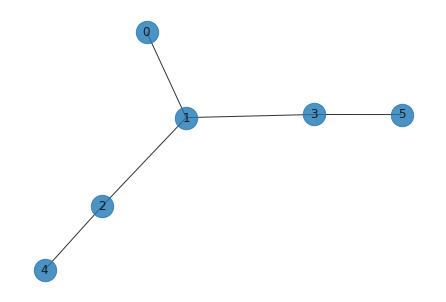

In [4]:
# Graph example B: a graph with 6 nodes
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5])
G.add_weighted_edges_from([(0, 1, 21), (1, 2, 17), (1, 3, 15), (2, 4, 25), (3, 5, 27)])
labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [5]:
adjacency = nx.adjacency_matrix(G).todense()
nnodes = G.number_of_nodes()
nclusters = 3
nqubits = nnodes * nclusters
print(adjacency)

/var/folders/mg/8gpvb2h14g715mgrnnm1rp940000gn/T/ipykernel_93943/2614419114.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


[[ 0 21  0  0  0  0]
 [21  0 17 15  0  0]
 [ 0 17  0  0 25  0]
 [ 0 15  0  0  0 27]
 [ 0  0 25  0  0  0]
 [ 0  0  0 27  0  0]]


## Mixing Unitary

In [6]:
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

┌───────────────┐
 q_0: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_1: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_2: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_3: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_4: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_5: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_6: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_7: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_8: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_9: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_10: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_11: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_12: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_13: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_14: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_15: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_16: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_17: ┤ Rx(2*$\beta$) ├
      └───────────────┘

## Problem Unitary (Cost Unitary)

### [1st term of the problem unitary] The term describing the graph geometry: Laplacian matrix

[[ 21 -21   0   0   0   0]
 [-21  53 -17 -15   0   0]
 [  0 -17  42   0 -25   0]
 [  0 -15   0  42   0 -27]
 [  0   0 -25   0  25   0]
 [  0   0   0 -27   0  27]]


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


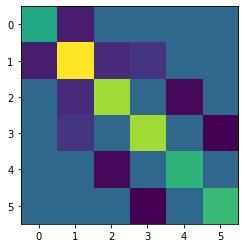

In [7]:
L = nx.laplacian_matrix(G, nodelist=None, weight='weight').todense()
print(L)
plt.imshow(L)

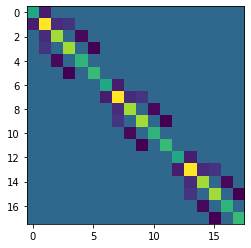

In [8]:
extended_L = np.zeros((nqubits, nqubits))
for i in range(nclusters):
    extended_L[i*nnodes:(i+1)*nnodes, i*nnodes:(i+1)*nnodes] += L
plt.imshow(extended_L)

### [2nd term of the problem unitary]  Constraint 1: the number of nodes in each cluster should be the same.

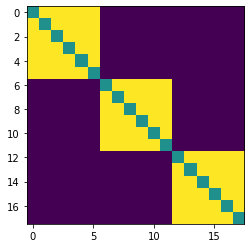

In [9]:
extended_c1 = np.zeros((nqubits, nqubits))

# quadratic terms
# naturally reduces to linear terms bc 1*1=1 and 0*0=0
for i in range(nqubits):
    extended_c1[i,i] += 1
#plt.imshow(extended_c1)

# linear terms
small_off_diagonal_matrix = np.ones((nnodes, nnodes))
for i in range(nnodes):
    small_off_diagonal_matrix[i, i] = 0
plt.plot()
# plt.imshow(small_off_diagonal_matrix)

for i in range(nclusters):
    extended_c1[i*nnodes:(i+1)*nnodes, i*nnodes:(i+1)*nnodes] += small_off_diagonal_matrix * (nnodes // nclusters)

plt.imshow(extended_c1)

### [3rd term of the problem unitary] Constraint 2: each node should be assigned to exactly one cluster.

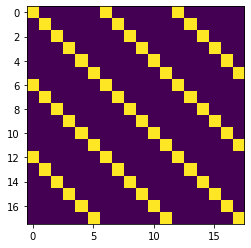

In [10]:
extended_c2 = np.zeros((nqubits, nqubits))

# quadratic terms
# naturally reduces to linear terms bc 1*1=1 and 0*0=0
for i in range(nqubits):
    extended_c2[i,i] += 1

# linear terms
small_diagonal_matrix = np.zeros((nnodes, nnodes))
for i in range(nnodes):
    small_diagonal_matrix[i, i] += 1

for i, j in product(np.arange(nclusters), np.arange(nclusters)):
    if i != j:
        extended_c2[i*nnodes: (i+1)*nnodes, j*nnodes: (j+1)*nnodes] += small_diagonal_matrix
        
plt.imshow(extended_c2)

### [total problem unitary] Weighted sum of the above 3 matrices

In [11]:
constraint_weight = 50
problem_unitary = extended_L + constraint_weight * extended_c1 + constraint_weight * 3 * extended_c2

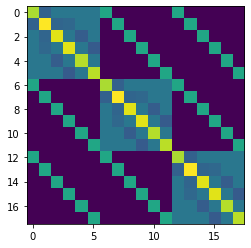

In [12]:
plt.imshow(problem_unitary)

In [27]:
# total =0
# for i, j in product(range(18), range(18)):
#     if i>j and (problem_unitary[i, j] != 0):
#         total += 1
# print(total)

63


### [total problem unitary] Converting the problem unitary to a quantum circuit
Each entry is a weighted ZZ gate

In [100]:
# # test = np.zeros_like(problem_unitary)
# gamma = Parameter("$\\gamma$")
# qc_p = QuantumCircuit(nqubits)    

# plt.imshow(test)
# for i, j in product(np.arange(nqubits), np.arange(nqubits)):
#     if (i < j) and (problem_unitary[i, j] != 0):
# #         test[i, j] = problem_unitary[i, j]
#         qc_p.rzz(2 * problem_unitary[i, j] * gamma, i, j)
#         qc_p.barrier()

# qc_p.decompose().draw()
# # plt.imshow(test)

In [ ]:
# test = np.zeros_like(problem_unitary)
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)    

plt.imshow(test)
for i, j in product(np.arange(nqubits), np.arange(nqubits)):
    if (i < j) and (problem_unitary[i, j] != 0):
#         test[i, j] = problem_unitary[i, j]
        qc_p.rzz(2 * problem_unitary[i, j] * gamma, i, j)
        qc_p.barrier()

qc_p.decompose().draw()
# plt.imshow(test)

# QAOA

In [21]:
# initial state
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
# qc_0.draw()

┌───┐
 q_0: ┤ H ├
      ├───┤
 q_1: ┤ H ├
      ├───┤
 q_2: ┤ H ├
      ├───┤
 q_3: ┤ H ├
      ├───┤
 q_4: ┤ H ├
      ├───┤
 q_5: ┤ H ├
      ├───┤
 q_6: ┤ H ├
      ├───┤
 q_7: ┤ H ├
      ├───┤
 q_8: ┤ H ├
      ├───┤
 q_9: ┤ H ├
      ├───┤
q_10: ┤ H ├
      ├───┤
q_11: ┤ H ├
      ├───┤
q_12: ┤ H ├
      ├───┤
q_13: ┤ H ├
      ├───┤
q_14: ┤ H ├
      ├───┤
q_15: ┤ H ├
      ├───┤
q_16: ┤ H ├
      ├───┤
q_17: ┤ H ├
      └───┘

In [22]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

┌─────────┐                                 ░                            »
 q_0: ┤ U2(0,π) ├──■──────────────────────────■───░───■────────────────────────»
      ├─────────┤┌─┴─┐┌────────────────────┐┌─┴─┐ ░   │                        »
 q_1: ┤ U2(0,π) ├┤ X ├┤ Rz(158.0*$\gamma$) ├┤ X ├─░───┼────────────────────────»
      ├─────────┤└───┘└────────────────────┘└───┘ ░ ┌─┴─┐┌────────────────────┐»
 q_2: ┤ U2(0,π) ├─────────────────────────────────░─┤ X ├┤ Rz(200.0*$\gamma$) ├»
      ├─────────┤                                 ░ └───┘└────────────────────┘»
 q_3: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
 q_4: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
 q_5: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
 q_6: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
 q_7: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
 q_8: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
 q_9: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
q_10: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
q_11: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
q_12: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
q_13: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
q_14: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
q_15: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
q_16: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      ├─────────┤                                 ░                            »
q_17: ┤ U2(0,π) ├─────────────────────────────────░────────────────────────────»
      └─────────┘                                 ░                            »
«            ░                                  ░                            »
« q_0: ──■───░───■──────────────────────────■───░───■────────────────────────»
«        │   ░   │                          │   ░   │                        »
« q_1: ──┼───░───┼──────────────────────────┼───░───┼────────────────────────»
«      ┌─┴─┐ ░   │                          │   ░   │                        »
« q_2: ┤ X ├─░───┼──────────────────────────┼───░───┼────────────────────────»
«      └───┘ ░ ┌─┴─┐┌────────────────────┐┌─┴─┐ ░   │                        »
« q_3: ──────░─┤ X ├┤ Rz(200.0*$\gamma$) ├┤ X ├─░───┼────────────────────────»
«            ░ └───┘└────────────────────┘└───┘ ░ ┌─┴─┐┌────────────────────┐»
« q_4: ──────░──────────────────────────────────░─┤ X ├┤ Rz(200.0*$\gamma$) ├»
«            ░                                  ░ └───┘└────────────────────┘»
« q_5: ──────░──────────────────────────────────░────────────────────────────»
«            ░                                  ░            

In [67]:
def cost(x):
    """
    Given a bitstring as a solution, this function 
    calculates the cost function for that solution
    
    Args:
        x: str
           solution bitstring
        
    Returns:
        obj: float
             Objective
    """
    return np.matmul(exp_x.transpose(), np.matmul(problem_unitary, exp_x))

In [68]:
def compute_expectation(counts):
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
        
    Returns:
        avg: float
             expectation value
    """
    
    total_cost = 0
    sum_count = 0
    for bitstring, count in counts.items():
        total_cost = cost(bitstring) * count
        sum_count += count
        
    return total_cost/sum_count

In [88]:
# build the qaoa circuit under a single function
def create_qaoa_circ(theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for i, j in product(np.arange(nqubits), np.arange(nqubits)):
            if (i < j) and (problem_unitary[i, j] != 0):
            #         test[i, j] = problem_unitary[i, j]
                qc.rzz(2 * problem_unitary[i, j] * gamma[irep], i, j)
                qc.barrier()

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc


def get_expectation(p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [89]:
from scipy.optimize import minimize

expectation = get_expectation(p=1)

res = minimize(expectation, 
                      [0.5, 0.5], 
                      method='COBYLA')

In [90]:
qc = create_qaoa_circ([0.1, 0.3])
qc.draw()

┌───┐            ░           ░           ░           ░           ░ »
    q_0: ┤ H ├─■──────────░──■────────░──■────────░──■────────░──■────────░─»
         ├───┤ │ZZ(47.4)  ░  │        ░  │        ░  │        ░  │        ░ »
    q_1: ┤ H ├─■──────────░──┼────────░──┼────────░──┼────────░──┼────────░─»
         ├───┤            ░  │ZZ(60)  ░  │        ░  │        ░  │        ░ »
    q_2: ┤ H ├────────────░──■────────░──┼────────░──┼────────░──┼────────░─»
         ├───┤            ░           ░  │ZZ(60)  ░  │        ░  │        ░ »
    q_3: ┤ H ├────────────░───────────░──■────────░──┼────────░──┼────────░─»
         ├───┤            ░           ░           ░  │ZZ(60)  ░  │        ░ »
    q_4: ┤ H ├────────────░───────────░───────────░──■────────░──┼────────░─»
         ├───┤            ░           ░           ░           ░  │ZZ(60)  ░ »
    q_5: ┤ H ├────────────░───────────░───────────░───────────░──■────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
    q_6: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
    q_7: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
    q_8: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
    q_9: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
   q_10: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
   q_11: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
   q_12: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
   q_13: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
   q_14: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
   q_15: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
   q_16: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         ├───┤            ░           ░           ░           ░           ░ »
   q_17: ┤ H ├────────────░───────────░───────────░───────────░───────────░─»
         └───┘            ░           ░           ░           ░           ░ »
meas: 18/═══════════════════════════════════════════════════════════════════»
                                                                            »
«                   ░           ░             ░           ░           ░ »
«    q_0: ─■────────░──■────────░─────────────░───────────░───────────░─»
«          │        ░  │        ░             ░           ░           ░ »
«    q_1: ─┼────────░──┼────────░──■──────────░──■────────░──■────────░─»
«          │        ░  │        ░  │ZZ(49.8)  ░  │        ░  │        ░ »
«    q_2: ─┼────────░──┼────────░──■──────────░──┼────────░──┼────────░─»
«          │        ░  │        ░             ░  │ZZ(51)  ░  │        ░ »
«    q_3: ─┼────────░──┼────────░─────────────░──■────────░──┼────────░─»
«          │        ░  │        ░             ░           ░  │ZZ(60)  ░ »
«    q_4: ─┼────────░──┼────────░─────────────░───────────░──■────────░─»
«          │        ░  │        ░             ░           ░           ░ »
«    q_5: ─┼────────░──┼────────░─────────────░───────────░───────────░─»
«          │ZZ(90)  ░  │        ░             ░           ░           ░ »
«    

In [96]:
counts = backend.run(qc, seed_simulator=10, nshots=100000000000).result().get_counts()

In [97]:
compute_expectation(counts)

5.685546875

In [99]:
counts

{'111010011001111110': 1,
 '010000111000001011': 1,
 '100111000100000111': 1,
 '111001111100001010': 1,
 '010011111001011111': 1,
 '001000110000110110': 1,
 '010111011101001000': 1,
 '100110110101000100': 1,
 '111000111100100000': 1,
 '101101010101111101': 1,
 '110100010010001100': 1,
 '010001100110100001': 1,
 '001110001001111100': 1,
 '101110011111110001': 1,
 '010011100011110110': 1,
 '100110110110001111': 1,
 '100001100000010101': 1,
 '001110101001100111': 1,
 '111010110110011001': 1,
 '011001010011101111': 1,
 '001010110010001011': 1,
 '011001100111010101': 1,
 '100000111000001000': 1,
 '010001101011011101': 1,
 '001010101101101110': 1,
 '010110000001110111': 1,
 '010000110110011001': 1,
 '100111111100100101': 1,
 '101000011011100000': 1,
 '001100001000110000': 1,
 '010110000111110111': 1,
 '011100010000100100': 1,
 '000111101100010110': 1,
 '111001101000110100': 1,
 '100011000011000111': 1,
 '100010111110011111': 1,
 '000110000011110011': 1,
 '110000010010110001': 1,
 '1010101011

In [76]:
backend = Aer.get_backend('qasm_simulator')
print(backend)


qasm_simulator


In [46]:
exp_x = np.array([0,1,0,0,1, 1,0,0,0,0, 1,1,1,0,1, 0,1,1])
print(exp_x.shape)

(18,)


In [47]:
np.matmul(exp_x.transpose(), np.matmul(problem_unitary, exp_x))

5822.0

In [49]:
problem_unitary.shape

(18, 18)